# Deep Learning Summer School 2025
## Capstone Project
## Roll Number: S215




## Project: Mental Health Detection from Social Media Posts
## Project Track: Natural Language Processing

1.   Dataset: Reddit Mental Health CSVs
2.   Goal: Classify posts into 4 classes: Depressed, Anxious, Stressed, Neutral

Steps:
 1. Setup & Install

Loading Reddit datasets...
Assigning labels based on subreddits...
Creating vocabulary and converting text to sequences...
Preparing data for training...
Label counts: {np.int64(3): 143, np.int64(0): 227, np.int64(1): 166}
Class weights: tensor([0.0043, 0.0059, 0.9829, 0.0069])
Setting up model parameters...
Training model...
Epoch 1/10, Loss: 0.0104
Epoch 2/10, Loss: 0.0103
Epoch 3/10, Loss: 0.0105
Epoch 4/10, Loss: 0.0104
Epoch 5/10, Loss: 0.0103
Epoch 6/10, Loss: 0.0104
Epoch 7/10, Loss: 0.0102
Epoch 8/10, Loss: 0.0103
Epoch 9/10, Loss: 0.0104
Epoch 10/10, Loss: 0.0103
Plotting loss curve...


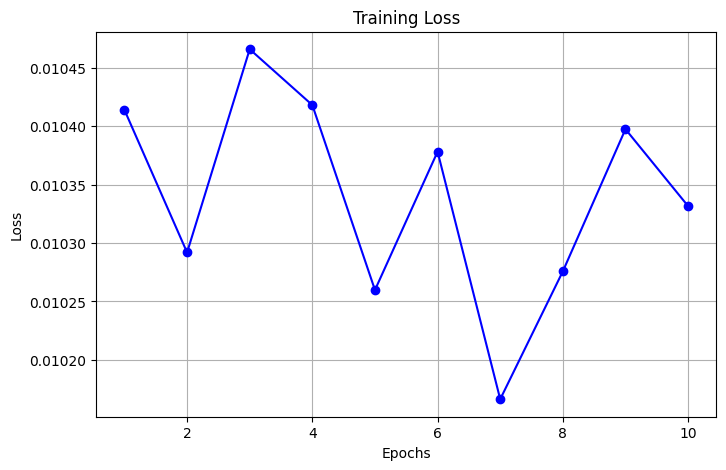

Evaluating model...
Accuracy: 0.3037037037037037

Classification Report:
               precision    recall  f1-score   support

   Depressed       0.40      0.45      0.43        51
     Anxious       0.60      0.07      0.12        45
    Stressed       0.00      0.00      0.00         0
     Neutral       0.31      0.38      0.34        39

    accuracy                           0.30       135
   macro avg       0.33      0.23      0.22       135
weighted avg       0.44      0.30      0.30       135


Confusion Matrix:
 [[23  1 10 17]
 [18  3  7 17]
 [ 0  0  0  0]
 [16  1  7 15]]
Predicting for: 'I feel worthless and overwhelmed'
Probabilities:
Depressed: 0.0044
Anxious: 0.2796
Stressed: 0.0000
Neutral: 0.7160
Predicted: Neutral

Predicting for: 'I'm managing my stress and doing okay'
Probabilities:
Depressed: 0.0084
Anxious: 0.3025
Stressed: 0.0000
Neutral: 0.6891
Predicted: Neutral

Predicting for: 'I have been panicking a lot lately'
Probabilities:
Depressed: 0.0065
Anxious: 0.26

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
import torch
import numpy as np
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
from collections import Counter
from torch.utils.data import DataLoader, TensorDataset

# Step 1: Load and Clean Data
def load_and_clean_data():
    print("Loading Reddit datasets...")
    # Update these paths to your actual CSV file locations
    csv_files = [
        "/content/LD DA 1.csv",
        "/content/LD PF1.csv",
        "/content/LD PF1.csv",
        "/content/LD TS 1.csv"
    ]
    try:
        dfs = [pd.read_csv(file) for file in csv_files]
    except FileNotFoundError:
        print("Error: One or more CSV files not found. Please check file paths.")
        return None

    # Combine datasets
    data = pd.concat(dfs, ignore_index=True)

    # Remove missing values
    data.dropna(subset=["selftext", "subreddit"], inplace=True)

    # Combine title and selftext
    data["text"] = data["title"].fillna("") + " " + data["selftext"]

    # Clean text
    def clean_text(text):
        text = text.lower()
        text = re.sub(r"http\S+", "", text)  # Remove URLs
        text = re.sub(r"[^a-z\s]", "", text)  # Keep letters and spaces
        return text.strip()

    data["clean_text"] = data["text"].apply(clean_text)
    return data

# Step 2: Map Subreddits to Labels
def map_labels(data):
    print("Assigning labels based on subreddits...")
    data = data.copy()  # Avoid SettingWithCopyWarning
    data["subreddit"] = data["subreddit"].str.lower()
    label_map = {"depression": 0, "anxiety": 1, "stress": 2, "mentalhealth": 3}
    data = data[data["subreddit"].isin(label_map.keys())]
    data["label"] = data["subreddit"].map(label_map)
    return data

# Step 3: Tokenize and Vectorize
def tokenize_and_vectorize(data):
    print("Creating vocabulary and converting text to sequences...")
    all_words = " ".join(data["clean_text"]).split()
    vocab = sorted(set(all_words))
    word_to_index = {word: idx + 1 for idx, word in enumerate(vocab)}  # 0 for padding

    def text_to_sequence(text, max_len=100):
        tokens = text.split()
        seq = [word_to_index.get(word, 0) for word in tokens]
        return seq[:max_len] + [0] * (max_len - len(seq))

    sequences = np.array([text_to_sequence(text) for text in data["clean_text"]])
    labels = data["label"].values
    return sequences, labels, word_to_index, len(vocab) + 1

# Step 4: Prepare Data
def prepare_data(sequences, labels):
    print("Preparing data for training...")
    X_train, X_test, y_train, y_test = train_test_split(sequences, labels, test_size=0.2, random_state=42)

    # Convert to tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.long)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)
    X_test_tensor = torch.tensor(X_test, dtype=torch.long)
    y_test_tensor = torch.tensor(y_test, dtype=torch.long)

    # Create DataLoader
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

    # Compute class weights
    label_counts = Counter(y_train)
    print("Label counts:", dict(label_counts))
    raw_weights = [1 / label_counts.get(i, 1) for i in range(4)]
    total = sum(raw_weights)
    class_weights = torch.tensor([w / total for w in raw_weights], dtype=torch.float32)
    print("Class weights:", class_weights)

    return X_train_tensor, X_test_tensor, y_train_tensor, y_test_tensor, train_loader, class_weights

# Step 5: Initialize Model
def initialize_model(vocab_size, embed_dim=50, num_classes=4):
    print("Setting up model parameters...")
    embedding = torch.randn(vocab_size, embed_dim, requires_grad=True)
    linear_W = torch.randn(embed_dim, num_classes, requires_grad=True)
    linear_b = torch.zeros(num_classes, requires_grad=True)
    return embedding, linear_W, linear_b

# Step 6: Model Functions
def softmax(x):
    exp_x = torch.exp(x - torch.max(x, dim=1, keepdim=True)[0])
    return exp_x / exp_x.sum(dim=1, keepdim=True)

def weighted_cross_entropy_loss(logits, labels, class_weights):
    log_probs = torch.log_softmax(logits, dim=1)  # Shape: (batch_size, num_classes)
    one_hot = torch.zeros_like(logits)  # Shape: (batch_size, num_classes)
    one_hot[range(len(labels)), labels] = 1.0
    weights = class_weights[labels].unsqueeze(1)  # Shape: (batch_size, 1)
    loss = -torch.sum(weights * (one_hot * log_probs)) / len(labels)
    return loss

def forward(X, embedding, linear_W, linear_b):
    emb = embedding[X]  # (batch, seq_len, embed_dim)
    avg_emb = emb.mean(dim=1)  # (batch, embed_dim)
    logits = avg_emb @ linear_W + linear_b  # (batch, num_classes)
    return logits

# Step 7: Train Model
def train_model(train_loader, embedding, linear_W, linear_b, class_weights):
    print("Training model...")
    learning_rate = 0.01
    epochs = 10
    losses = []

    for epoch in range(epochs):
        total_loss = 0
        num_batches = 0
        for batch_X, batch_y in train_loader:
            logits = forward(batch_X, embedding, linear_W, linear_b)
            loss = weighted_cross_entropy_loss(logits, batch_y, class_weights)
            total_loss += loss.item()
            num_batches += 1

            loss.backward()
            with torch.no_grad():
                embedding -= learning_rate * embedding.grad
                linear_W -= learning_rate * linear_W.grad
                linear_b -= learning_rate * linear_b.grad
                embedding.grad.zero_()
                linear_W.grad.zero_()
                linear_b.grad.zero_()

        avg_loss = total_loss / num_batches
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")
        losses.append(avg_loss)

    return losses

# Step 8: Evaluate Model
def evaluate_model(X_test, y_test, embedding, linear_W, linear_b):
    print("Evaluating model...")
    with torch.no_grad():
        logits = forward(X_test, embedding, linear_W, linear_b)
        probs = softmax(logits)
        y_pred = torch.argmax(probs, dim=1)

    y_test_np = y_test.numpy()
    y_pred_np = y_pred.numpy()

    print("Accuracy:", accuracy_score(y_test_np, y_pred_np))
    print("\nClassification Report:\n", classification_report(
        y_test_np, y_pred_np, target_names=["Depressed", "Anxious", "Stressed", "Neutral"]
    ))
    print("\nConfusion Matrix:\n", confusion_matrix(y_test_np, y_pred_np))

# Step 9: Plot Loss
def plot_loss(losses):
    print("Plotting loss curve...")
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(losses) + 1), losses, marker='o', color='blue')
    plt.title("Training Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.show()

# Step 10: Predict New Text
def predict_text(text, word_to_index, embedding, linear_W, linear_b):
    print(f"Predicting for: '{text}'")
    text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"[^a-z\s]", "", text)
    tokens = text.split()
    seq = [word_to_index.get(word, 0) for word in tokens]
    seq = seq[:100] + [0] * (100 - len(seq))
    input_tensor = torch.tensor([seq], dtype=torch.long)

    with torch.no_grad():
        logits = forward(input_tensor, embedding, linear_W, linear_b)
        probs = softmax(logits)
        pred_class = torch.argmax(probs, dim=1).item()

    idx_to_label = {0: "Depressed", 1: "Anxious", 2: "Stressed", 3: "Neutral"}
    print("Probabilities:")
    for i, prob in enumerate(probs[0]):
        print(f"{idx_to_label[i]}: {prob.item():.4f}")
    return idx_to_label[pred_class]

# Main Function
def main():
    # Load and preprocess data
    data = load_and_clean_data()
    if data is None:
        return

    # Map labels
    data = map_labels(data)

    # Tokenize and vectorize
    sequences, labels, word_to_index, vocab_size = tokenize_and_vectorize(data)

    # Prepare data
    X_train, X_test, y_train, y_test, train_loader, class_weights = prepare_data(sequences, labels)

    # Initialize model
    embedding, linear_W, linear_b = initialize_model(vocab_size)

    # Train model
    losses = train_model(train_loader, embedding, linear_W, linear_b, class_weights)

    # Plot loss
    plot_loss(losses)

    # Evaluate model
    evaluate_model(X_test, y_test, embedding, linear_W, linear_b)

    # Test predictions
    test_texts = [
        "I feel worthless and overwhelmed",
        "I'm managing my stress and doing okay",
        "I have been panicking a lot lately",
        "Today was a good day. I feel normal"
    ]
    for text in test_texts:
        pred = predict_text(text, word_to_index, embedding, linear_W, linear_b)
        print(f"Predicted: {pred}\n")

# Run the project
if __name__ == "__main__":
    main()